In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))


Using cpu device


Random Color:


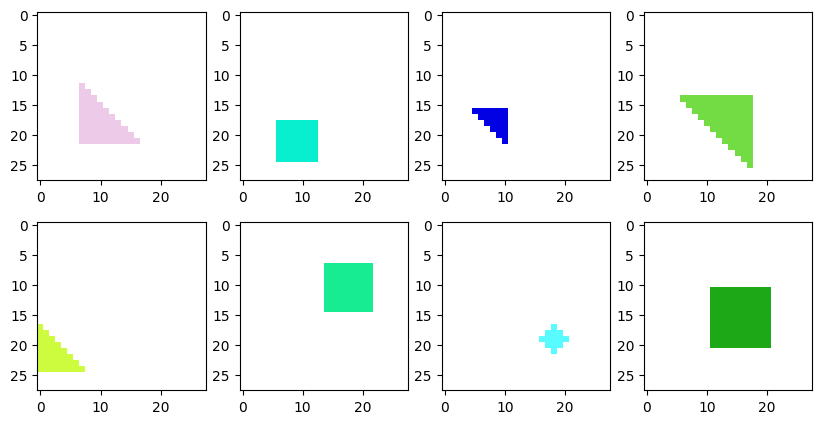

Fixed Color:


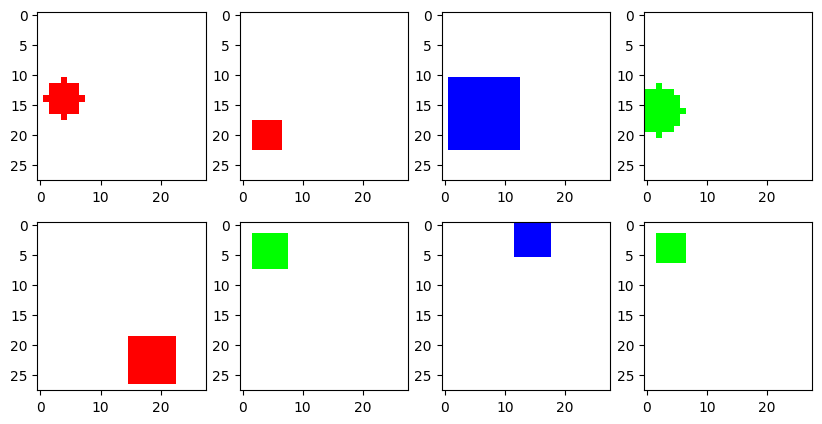

In [16]:


class GeometricFiguresDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples=2000, image_size=(28, 28), random_color=True, color_list=None):
        self.num_samples = num_samples
        self.image_size = image_size
        self.random_color = random_color
        self.color_list = color_list

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image, label = self.generate_image()
        image_tensor = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        label_tensor = torch.tensor(label)
        return image_tensor, label_tensor

    def generate_image(self):
        image = np.ones((self.image_size[0], self.image_size[1], 3), dtype=np.uint8) * 255  # White background

        shape = np.random.choice(['square', 'circle', 'triangle'])
        color = self.choose_color()
        size = np.random.randint(3, self.image_size[0] // 2)
        pos_x = np.random.randint(0, self.image_size[1] - size)
        pos_y = np.random.randint(0, self.image_size[0] - size)

        if shape == 'square':
            image = self.draw_square(image, x = pos_x, y = pos_y,  size=size, color=color)
        elif shape=='circle':
            image = self.draw_circle(image, x = pos_x, y = pos_y, radius=size//2, color=color)
        else:
            image = self.draw_triangle(image, x = pos_x, y = pos_y, size=size, color=color)

        #label is the shape, color, size and position of the shape
        shape_dict = {'square': 0, 'circle': 1, 'triangle': 2}
        label = np.array([shape_dict[shape],  size, pos_x, pos_y, color[0], color[1], color[2]])


        return image, label

    def choose_color(self):
        if self.random_color:
            return np.random.randint(0, 256, size=3)  # Random RGB color
        else:
            #return np.random.choice(self.color_list)
            color_r = np.array([255, 0, 0])
            color_g = np.array([0, 255, 0])
            color_b = np.array([0, 0, 255])
            #return one of the three colors
            rand_col = np.random.randint(0, 3)
            if rand_col == 0:
                return color_r
            elif rand_col == 1:
                return color_g
            else:
                return color_b


    def draw_square(self, image, x, y, size, color):
        image[y:y+size, x:x+size] = color
        return image

    def draw_triangle(self, image, x, y, size, color):
        image[y:y+size, x:x+size] = color

        # Determine whether to remove upper or lower half of the square
        if np.random.rand() < 0.5:
            # Remove upper half of the square
            for i in range(size):
                for j in range(size):
                    if i > j:
                        image[y+i, x+j] = 255  # Background color
        else:
            # Remove lower half of the square
            for i in range(size):
                for j in range(size):
                    if i < j:
                        image[y+i, x+j] = 255  # Background color
        return image

    def draw_circle(self, image, x, y, radius, color):

        yy, xx = np.ogrid[-y:image.shape[0]-y, -x:image.shape[1]-x]
        mask = xx*xx + yy*yy <= radius*radius
        image[mask] = color
        return image


dataset_random_color = GeometricFiguresDataset(random_color=True)
dataloader_random_color = torch.utils.data.DataLoader(dataset_random_color, batch_size=8, shuffle=True)

dataset_fixed_color = GeometricFiguresDataset(random_color=False, color_list=[[255, 0, 0], [0, 255, 0], [0, 0, 255]])
dataloader_fixed_color = torch.utils.data.DataLoader(dataset_fixed_color, batch_size=8, shuffle=True)

# Visualize some samples with random color
print("Random Color:")
for batch in dataloader_random_color:
    batch = batch[0]
    plt.figure(figsize=(10, 5))
    for i in range(batch.size(0)):
        plt.subplot(2, 4, i+1)
        plt.imshow(batch[i].permute(1, 2, 0).numpy())
        #plt.axis('off')
    plt.show()
    break  # Only visualize one batch

# Visualize some samples with fixed color
print("Fixed Color:")
for batch in dataloader_fixed_color:
    batch = batch[0]
    plt.figure(figsize=(10, 5))
    for i in range(batch.size(0)):
        plt.subplot(2, 4, i+1)
        plt.imshow(batch[i].permute(1, 2, 0).numpy())
        #plt.axis('off')
    plt.show()
    break  # Only visualize one batch


In [17]:
batch_size = 128

dataset = GeometricFiguresDataset(random_color=False)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [18]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=2):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(16*7*7, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dim=2):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 16*7*7)
        self.conv2 = nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv1 = nn.ConvTranspose2d(8, 3, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 16, 7, 7)
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x))
        return x


In [19]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [20]:
def train(autoencoder, data, epochs=10, lr = 1e-3):
    opt = torch.optim.Adam(autoencoder.parameters(), lr=lr)
    for epoch in range(epochs):
        loss = 0
        for x in data:
            x, y = x
            x = x.to(device)
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
            loss += loss.item()
        print(f" Epoch {epoch+1} -> Loss: {loss/len(data)}")

    return autoencoder


In [26]:
autoencoder = Autoencoder(latent_dims=7).to(device)



In [28]:
autoencoder = train(autoencoder, dataloader, epochs=250, lr = 1e-2)

 Epoch 1 -> Loss: 1099.0
 Epoch 2 -> Loss: 1022.75
 Epoch 3 -> Loss: 981.0
 Epoch 4 -> Loss: 1011.75
 Epoch 5 -> Loss: 914.25
 Epoch 6 -> Loss: 1134.75
 Epoch 7 -> Loss: 936.75
 Epoch 8 -> Loss: 973.75
 Epoch 9 -> Loss: 1101.25
 Epoch 10 -> Loss: 946.0
 Epoch 11 -> Loss: 1018.75
 Epoch 12 -> Loss: 1098.75
 Epoch 13 -> Loss: 1004.5
 Epoch 14 -> Loss: 1070.0
 Epoch 15 -> Loss: 975.0
 Epoch 16 -> Loss: 1242.75
 Epoch 17 -> Loss: 1051.25
 Epoch 18 -> Loss: 1078.5
 Epoch 19 -> Loss: 1039.25
 Epoch 20 -> Loss: 1186.5
 Epoch 21 -> Loss: 1243.25
 Epoch 22 -> Loss: 1038.0
 Epoch 23 -> Loss: 1083.75
 Epoch 24 -> Loss: 1029.75
 Epoch 25 -> Loss: 1073.25
 Epoch 26 -> Loss: 944.5
 Epoch 27 -> Loss: 943.25
 Epoch 28 -> Loss: 833.25
 Epoch 29 -> Loss: 958.0
 Epoch 30 -> Loss: 1148.75
 Epoch 31 -> Loss: 969.25
 Epoch 32 -> Loss: 1185.5
 Epoch 33 -> Loss: 1037.0
 Epoch 34 -> Loss: 1037.0
 Epoch 35 -> Loss: 994.5
 Epoch 36 -> Loss: 1109.25
 Epoch 37 -> Loss: 1084.75
 Epoch 38 -> Loss: 1125.75
 Epoch 39 

KeyboardInterrupt: 

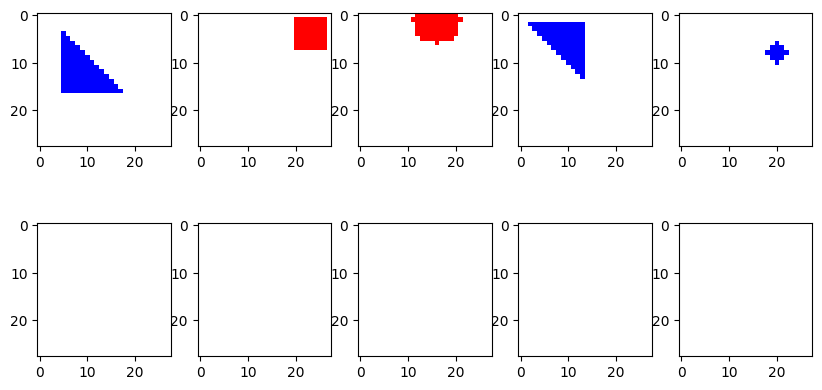

In [29]:
vis_batch = next(iter(dataloader))
vis_batch = vis_batch[0].to(device)

vis_recon = autoencoder(vis_batch)[0:5]

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(vis_batch[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(2, 5, i+6)
    plt.imshow(vis_recon[i].permute(1, 2, 0).cpu().detach().numpy())